In [1]:
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from time import sleep
import pandas as pd
import datetime

# epoch timestamp: 1483228800
start_from = datetime.datetime(2017,1,1,8,0,0).strftime('%s') 

gafata = ['^GSPC', 'GOOG', 'AAPL', 'FB', 'AMZN', '0700.HK', 'BABA']

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
driver = webdriver.Chrome('/usr/local/bin/chromedriver', options = chrome_options)

# get all csv files
driver.get(f'https://finance.yahoo.com/quote/{gafata[0]}/history')
sleep(5)

download_link = driver.find_element_by_xpath("// a[. // span[text() = 'Download Data']]").get_attribute("href")
for symbol in gafata:
    period1_changed = re.sub(r'period1=(\d+)', 'period1=1483228800', download_link)
    # if interval=1d, then stocks from various global exchanges would not align to each other in terms of date.
    interval_changed = re.sub(r'interval=(.*)&', 'interval=1wk&', period1_changed)
    dataURL = re.sub(r'download\/.*\?', f'download/{symbol}?', interval_changed)
    driver.get(dataURL)
    print(f'{symbol}.csv contains', pd.read_csv(f'{symbol}.csv').shape[0], 'lines')
    


^GSPC.csv contains 164 lines
GOOG.csv contains 164 lines
AAPL.csv contains 164 lines
FB.csv contains 164 lines
AMZN.csv contains 164 lines
0700.HK.csv contains 164 lines
BABA.csv contains 164 lines


In [2]:
# extract price of "Adjusted Close"

series = pd.DataFrame()
df = pd.read_csv(f'{gafata[0]}.csv')
number_of_rows = df.shape[0]
series['Date'] = df['Date'].tolist()

for symbol in gafata:
    series[f'{symbol}'] = pd.read_csv(f'{symbol}.csv')['Adj Close'].tolist()
print(series)

           Date        ^GSPC         GOOG        AAPL          FB  \
0    2017-01-01  2276.979980   806.150024  112.368469  123.410004   
1    2017-01-08  2274.639893   807.880005  113.445343  128.339996   
2    2017-01-15  2271.310059   805.020020  114.360237  127.040001   
3    2017-01-22  2294.689941   823.309998  116.218582  132.179993   
4    2017-01-29  2297.419922   801.489990  123.013496  130.979996   
..          ...          ...          ...         ...         ...   
159  2020-01-19  3295.469971  1466.709961  317.556335  217.940002   
160  2020-01-26  3225.520020  1434.229980  308.777191  201.910004   
161  2020-02-02  3327.709961  1479.229980  319.272278  212.330002   
162  2020-02-09  3352.090088  1508.680054  321.549988  213.059998   
163  2020-02-10  3352.090088  1508.680054  321.549988  213.059998   

            AMZN     0700.HK        BABA  
0     795.989990  193.701157   93.889999  
1     817.140015  198.268158   96.269997  
2     808.330017  196.282501   96.059998  

In [3]:
# add columns of "price change from the start"

gspc_pc, goog_pc, aapl_pc, fb_pc, amzn_pc, hk700_pc, baba_pc, base = [], [], [], [], [], [], [], []
for i in range(0, number_of_rows):
    gspc_pc.append(float(series.at[i, "^GSPC"])/float(series.at[0, "^GSPC"]) - 1)
    goog_pc.append(float(series.at[i, "GOOG"])/float(series.at[0, "GOOG"]) - 1)
    aapl_pc.append(float(series.at[i, "AAPL"])/float(series.at[0, "AAPL"]) - 1)
    fb_pc.append(float(series.at[i, "FB"])/float(series.at[0, "FB"]) - 1)
    amzn_pc.append(float(series.at[i, "AMZN"])/float(series.at[0, "AMZN"]) - 1)
    hk700_pc.append(float(series.at[i, "0700.HK"])/float(series.at[0, "0700.HK"]) - 1)
    baba_pc.append(float(series.at[i, "BABA"])/float(series.at[0, "BABA"]) - 1)
    base.append(0)

series['c^GSPC'], series['cGOOG'], series['cAAPL'], series['cFB'], series['cAMZN'], \
    series['c0700.HK'], series['cBABA'], series['base'] = \
    gspc_pc, goog_pc, aapl_pc, fb_pc, amzn_pc, hk700_pc, baba_pc, base

print(series)    

           Date        ^GSPC         GOOG        AAPL          FB  \
0    2017-01-01  2276.979980   806.150024  112.368469  123.410004   
1    2017-01-08  2274.639893   807.880005  113.445343  128.339996   
2    2017-01-15  2271.310059   805.020020  114.360237  127.040001   
3    2017-01-22  2294.689941   823.309998  116.218582  132.179993   
4    2017-01-29  2297.419922   801.489990  123.013496  130.979996   
..          ...          ...          ...         ...         ...   
159  2020-01-19  3295.469971  1466.709961  317.556335  217.940002   
160  2020-01-26  3225.520020  1434.229980  308.777191  201.910004   
161  2020-02-02  3327.709961  1479.229980  319.272278  212.330002   
162  2020-02-09  3352.090088  1508.680054  321.549988  213.059998   
163  2020-02-10  3352.090088  1508.680054  321.549988  213.059998   

            AMZN     0700.HK        BABA    c^GSPC     cGOOG     cAAPL  \
0     795.989990  193.701157   93.889999  0.000000  0.000000  0.000000   
1     817.140015  198.2

In [4]:
# assuming you're investing regularly, this column set the amount of total invested.

weekly_invested = 1000
total_invested = []
for i in range(0, number_of_rows):
    total_invested.append((i+1)*weekly_invested)
series['Total Invested'] = total_invested

print(series)

           Date        ^GSPC         GOOG        AAPL          FB  \
0    2017-01-01  2276.979980   806.150024  112.368469  123.410004   
1    2017-01-08  2274.639893   807.880005  113.445343  128.339996   
2    2017-01-15  2271.310059   805.020020  114.360237  127.040001   
3    2017-01-22  2294.689941   823.309998  116.218582  132.179993   
4    2017-01-29  2297.419922   801.489990  123.013496  130.979996   
..          ...          ...          ...         ...         ...   
159  2020-01-19  3295.469971  1466.709961  317.556335  217.940002   
160  2020-01-26  3225.520020  1434.229980  308.777191  201.910004   
161  2020-02-02  3327.709961  1479.229980  319.272278  212.330002   
162  2020-02-09  3352.090088  1508.680054  321.549988  213.059998   
163  2020-02-10  3352.090088  1508.680054  321.549988  213.059998   

            AMZN     0700.HK        BABA    c^GSPC     cGOOG     cAAPL  \
0     795.989990  193.701157   93.889999  0.000000  0.000000  0.000000   
1     817.140015  198.2

In [5]:
# weekly bought shares

gspc_wb, goog_wb, aapl_wb, fb_wb, amzn_wb, hk700_wb, baba_wb = [], [], [], [], [], [], []
for i in range(0, number_of_rows):
    gspc_wb.append(weekly_invested / float(series.at[i, "^GSPC"]))
    goog_wb.append(weekly_invested / float(series.at[i, "GOOG"]))
    aapl_wb.append(weekly_invested / float(series.at[i, "AAPL"]))
    fb_wb.append(weekly_invested / float(series.at[i, "FB"]))
    amzn_wb.append(weekly_invested / float(series.at[i, "AMZN"]))
    hk700_wb.append(weekly_invested / float(series.at[i, "0700.HK"]))
    baba_wb.append(weekly_invested / float(series.at[i, "BABA"]))

series['wb^GSPC'], series['wbGOOG'], series['wbAAPL'], series['wbFB'], series['wbAMZN'], \
    series['wb0700.HK'], series['wbBABA'] = \
    gspc_wb, goog_wb, aapl_wb, fb_wb, amzn_wb, hk700_wb, baba_wb
print(series)

           Date        ^GSPC         GOOG        AAPL          FB  \
0    2017-01-01  2276.979980   806.150024  112.368469  123.410004   
1    2017-01-08  2274.639893   807.880005  113.445343  128.339996   
2    2017-01-15  2271.310059   805.020020  114.360237  127.040001   
3    2017-01-22  2294.689941   823.309998  116.218582  132.179993   
4    2017-01-29  2297.419922   801.489990  123.013496  130.979996   
..          ...          ...          ...         ...         ...   
159  2020-01-19  3295.469971  1466.709961  317.556335  217.940002   
160  2020-01-26  3225.520020  1434.229980  308.777191  201.910004   
161  2020-02-02  3327.709961  1479.229980  319.272278  212.330002   
162  2020-02-09  3352.090088  1508.680054  321.549988  213.059998   
163  2020-02-10  3352.090088  1508.680054  321.549988  213.059998   

            AMZN     0700.HK        BABA    c^GSPC     cGOOG  ...     cBABA  \
0     795.989990  193.701157   93.889999  0.000000  0.000000  ...  0.000000   
1     817.140

In [6]:
# value accumulated

gspc_va, goog_va, aapl_va, fb_va, amzn_va, hk700_va, baba_va = [], [], [], [], [], [], []
for symbol in gafata:
    value_accumulated = []
    for i in range(0, number_of_rows):
        holding = 0
        for j in range(0, i+1):
            holding += series.at[j, f'wb{symbol}']
        value_accumulated.append(holding * series.at[i, f'{symbol}'] )
    series[f'va{symbol}'] = value_accumulated    
print(series)

           Date        ^GSPC         GOOG        AAPL          FB  \
0    2017-01-01  2276.979980   806.150024  112.368469  123.410004   
1    2017-01-08  2274.639893   807.880005  113.445343  128.339996   
2    2017-01-15  2271.310059   805.020020  114.360237  127.040001   
3    2017-01-22  2294.689941   823.309998  116.218582  132.179993   
4    2017-01-29  2297.419922   801.489990  123.013496  130.979996   
..          ...          ...          ...         ...         ...   
159  2020-01-19  3295.469971  1466.709961  317.556335  217.940002   
160  2020-01-26  3225.520020  1434.229980  308.777191  201.910004   
161  2020-02-02  3327.709961  1479.229980  319.272278  212.330002   
162  2020-02-09  3352.090088  1508.680054  321.549988  213.059998   
163  2020-02-10  3352.090088  1508.680054  321.549988  213.059998   

            AMZN     0700.HK        BABA    c^GSPC     cGOOG  ...    wbAMZN  \
0     795.989990  193.701157   93.889999  0.000000  0.000000  ...  1.256297   
1     817.140

In [7]:
# value accumulated for gafata as whole
value_accumulated_gafata = []
for i in range(0, number_of_rows):
    value = 0
    for symbol in gafata[1:]:       # excluding ^GPSC
        value += series.at[i, f'va{symbol}']
    value_accumulated_gafata.append(value)
series['vaGAFATA'] = value_accumulated_gafata
print(series)

           Date        ^GSPC         GOOG        AAPL          FB  \
0    2017-01-01  2276.979980   806.150024  112.368469  123.410004   
1    2017-01-08  2274.639893   807.880005  113.445343  128.339996   
2    2017-01-15  2271.310059   805.020020  114.360237  127.040001   
3    2017-01-22  2294.689941   823.309998  116.218582  132.179993   
4    2017-01-29  2297.419922   801.489990  123.013496  130.979996   
..          ...          ...          ...         ...         ...   
159  2020-01-19  3295.469971  1466.709961  317.556335  217.940002   
160  2020-01-26  3225.520020  1434.229980  308.777191  201.910004   
161  2020-02-02  3327.709961  1479.229980  319.272278  212.330002   
162  2020-02-09  3352.090088  1508.680054  321.549988  213.059998   
163  2020-02-10  3352.090088  1508.680054  321.549988  213.059998   

            AMZN     0700.HK        BABA    c^GSPC     cGOOG  ...  wb0700.HK  \
0     795.989990  193.701157   93.889999  0.000000  0.000000  ...   5.162592   
1     817.1

In [8]:
# regularlin investing on each stock, profit rate of total invested. 

gspc_rivc, goog_rivc, aapl_rivc, fb_rivc, amzn_rivc, hk700_rivc, baba_rivc, gafata_rivc = [], [], [], [], [], [], [], []
for i in range(0, number_of_rows):
    gspc_rivc.append(float(series.at[i, "va^GSPC"])/ float(series.at[i, "Total Invested"]) - 1)
    goog_rivc.append(float(series.at[i, "vaGOOG"]) / float(series.at[i, "Total Invested"]) - 1)
    aapl_rivc.append(float(series.at[i, "vaAAPL"]) / float(series.at[i, "Total Invested"]) - 1)
    fb_rivc.append(float(series.at[i, "vaFB"]) / float(series.at[i, "Total Invested"]) - 1)
    amzn_rivc.append(float(series.at[i, "vaAMZN"]) / float(series.at[i, "Total Invested"]) - 1)
    hk700_rivc.append(float(series.at[i, "va0700.HK"]) / float(series.at[i, "Total Invested"]) - 1)
    baba_rivc.append(float(series.at[i, "vaBABA"]) / float(series.at[i, "Total Invested"]) - 1)
    gafata_rivc.append(float(series.at[i, "vaGAFATA"]) / (float(series.at[i, "Total Invested"]) * 6) - 1)

series['rivc^GSPC'], series['rivcGOOG'], series['rivcAAPL'], series['rivcFB'], series['rivcAMZN'], \
    series['rivc0700.HK'], series['rivcBABA'], series['rivcGAFATA'] = \
    gspc_rivc, goog_rivc, aapl_rivc, fb_rivc, amzn_rivc, hk700_rivc, baba_rivc, gafata_rivc
print(series)

           Date        ^GSPC         GOOG        AAPL          FB  \
0    2017-01-01  2276.979980   806.150024  112.368469  123.410004   
1    2017-01-08  2274.639893   807.880005  113.445343  128.339996   
2    2017-01-15  2271.310059   805.020020  114.360237  127.040001   
3    2017-01-22  2294.689941   823.309998  116.218582  132.179993   
4    2017-01-29  2297.419922   801.489990  123.013496  130.979996   
..          ...          ...          ...         ...         ...   
159  2020-01-19  3295.469971  1466.709961  317.556335  217.940002   
160  2020-01-26  3225.520020  1434.229980  308.777191  201.910004   
161  2020-02-02  3327.709961  1479.229980  319.272278  212.330002   
162  2020-02-09  3352.090088  1508.680054  321.549988  213.059998   
163  2020-02-10  3352.090088  1508.680054  321.549988  213.059998   

            AMZN     0700.HK        BABA    c^GSPC     cGOOG  ...  \
0     795.989990  193.701157   93.889999  0.000000  0.000000  ...   
1     817.140015  198.268158   96

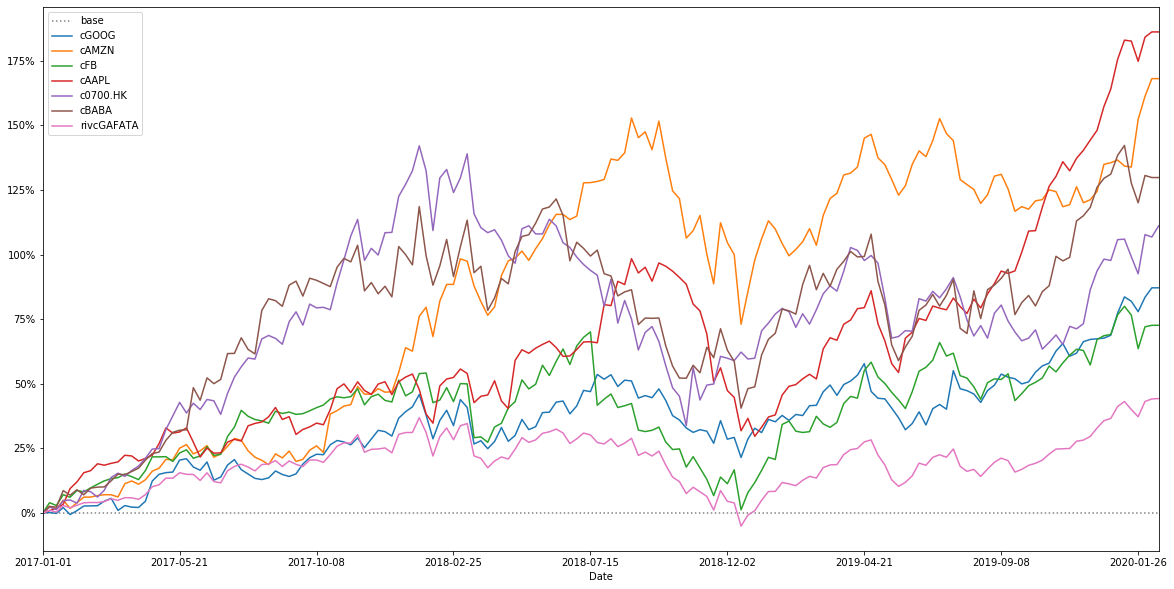

In [10]:
# draw the figure

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
series.plot(kind='line', linestyle='dotted', x='Date', y='base', ax=ax, figsize = (20,10), color="gray")
lines = ['cGOOG', 'cAMZN', 'cFB', 'cAAPL', 'c0700.HK', 'cBABA', 'rivcGAFATA']
for line in lines:
    series.plot(kind='line', linestyle='solid', x='Date', y=line, ax=ax, figsize = (20,10))

plt.show()